# Stage 15 Finetune Prediction Overview

Scatter summaries of run-level finetune predictions once all 15 pretrain tasks have been introduced. Each panel aggregates all runs for one PI property.


In [1]:
import json
from pathlib import Path
from typing import Dict, Iterable

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ARTIFACT_ROOT = Path("../artifacts/polymers_pretrain_finetune_runs")
STAGE_INDEX = 15
FINETUNE_PROPERTIES = [
    "density",
    "Rg",
    "r2",
    "self-diffusion",
    "Cp",
    "Cv",
    "linear_expansion",
    "refractive_index",
    "tg",
]

if not ARTIFACT_ROOT.exists():
    raise FileNotFoundError(f"Expected artifact directory at {ARTIFACT_ROOT}")

In [3]:
def collect_stage_predictions(artifact_root: Path, stage_index: int) -> Dict[str, pd.DataFrame]:
    property_frames: Dict[str, list[pd.DataFrame]] = {name: [] for name in FINETUNE_PROPERTIES}
    for run_dir in sorted(artifact_root.glob("run*")):
        if not run_dir.is_dir():
            continue
        for stage_dir in sorted(run_dir.glob(f"pretrain_stage{stage_index:02d}_*")):
            finetune_root = stage_dir / "finetune"
            if not finetune_root.exists():
                continue
            for property_name in FINETUNE_PROPERTIES:
                prediction_path = finetune_root / property_name.replace("-", "_") / "prediction" / "predictions.parquet"
                if prediction_path.exists():
                    frame = pd.read_parquet(prediction_path)
                    frame["run_dir"] = run_dir.name
                    property_frames[property_name].append(frame)
    return {
        name: pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
        for name, frames in property_frames.items()
    }

In [4]:
prediction_data = collect_stage_predictions(ARTIFACT_ROOT, STAGE_INDEX)
summary_counts = {name: len(df) for name, df in prediction_data.items()}
summary_counts

{'density': 1090,
 'Rg': 1090,
 'r2': 1080,
 'self-diffusion': 1090,
 'Cp': 1090,
 'Cv': 1090,
 'linear_expansion': 1090,
 'refractive_index': 1080,
 'tg': 1030}

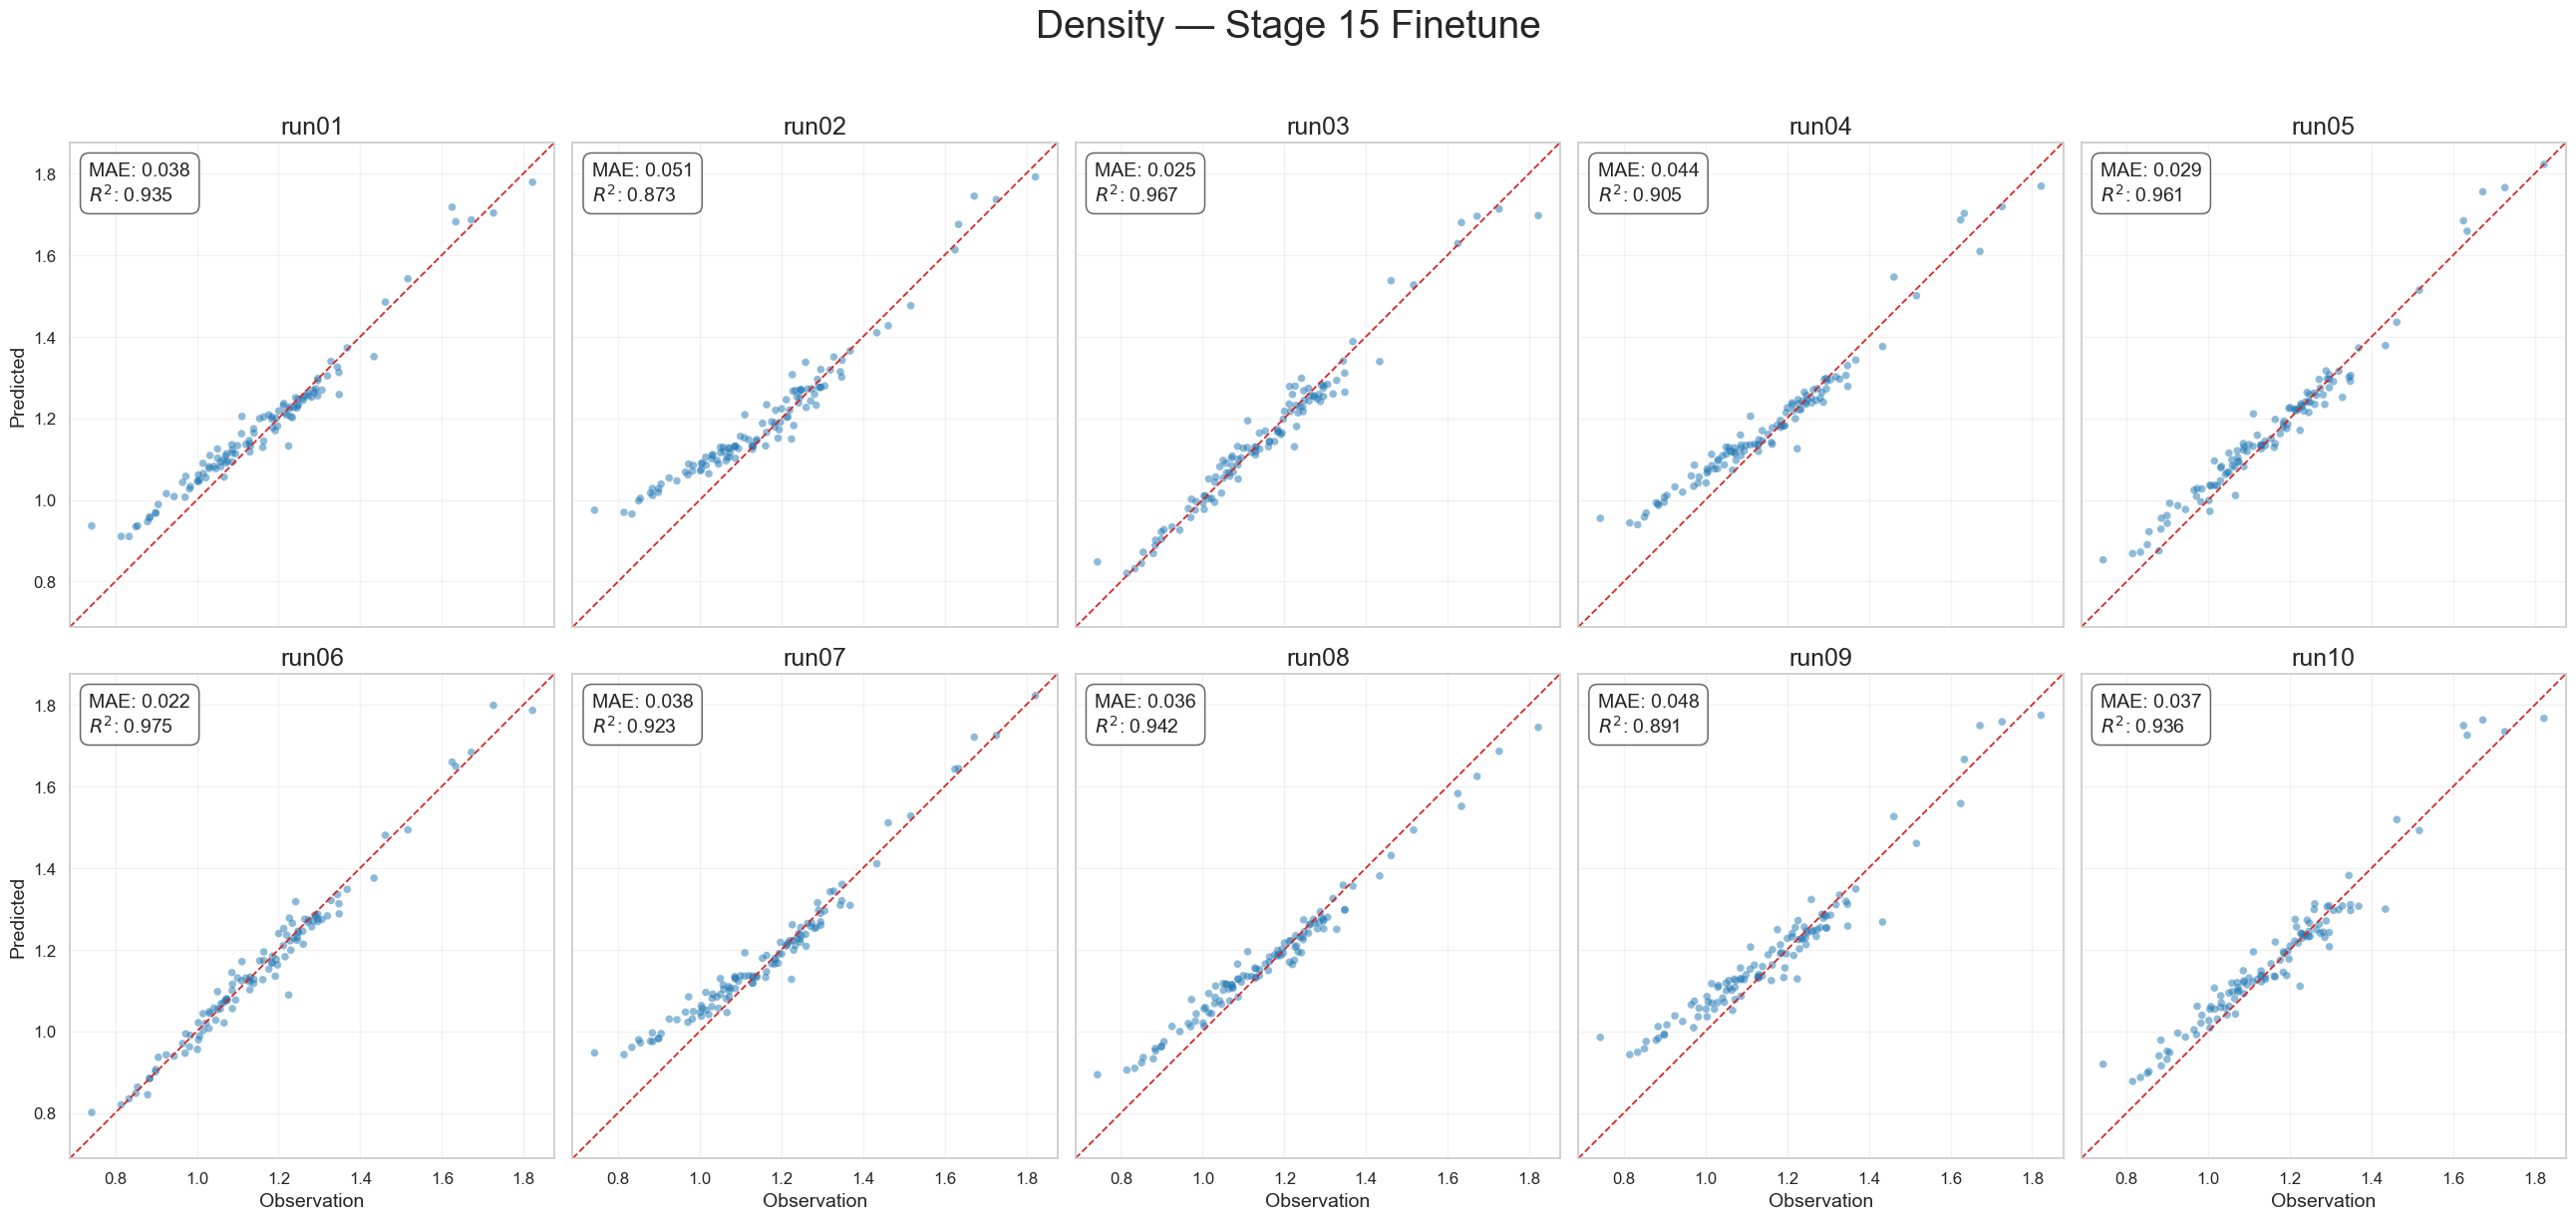

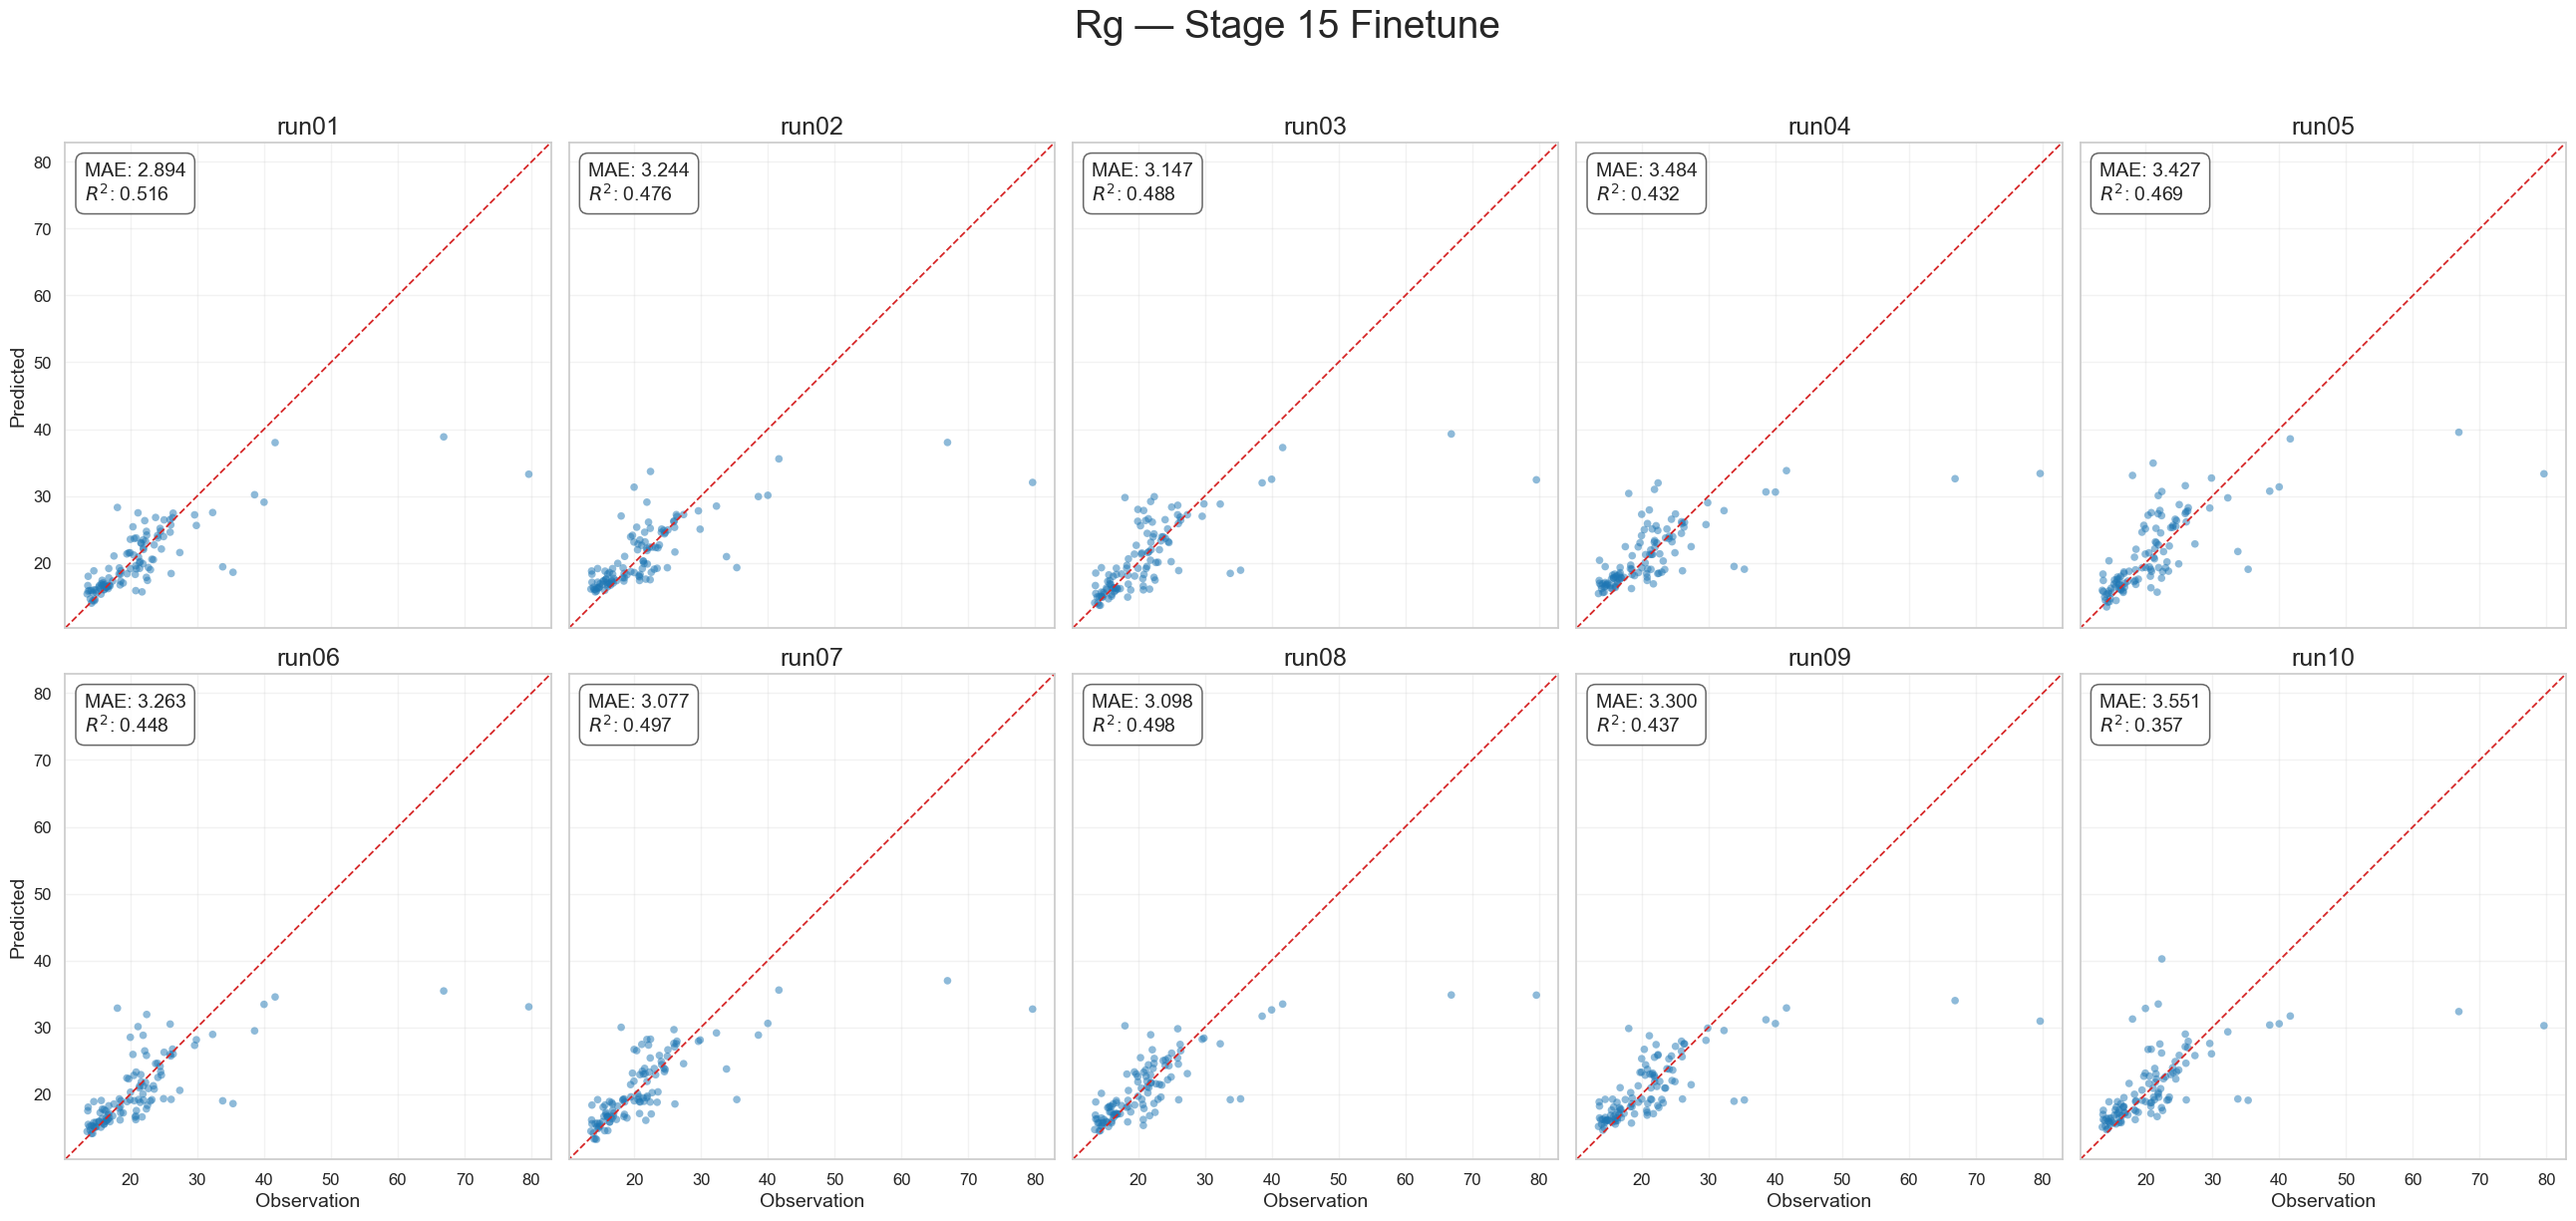

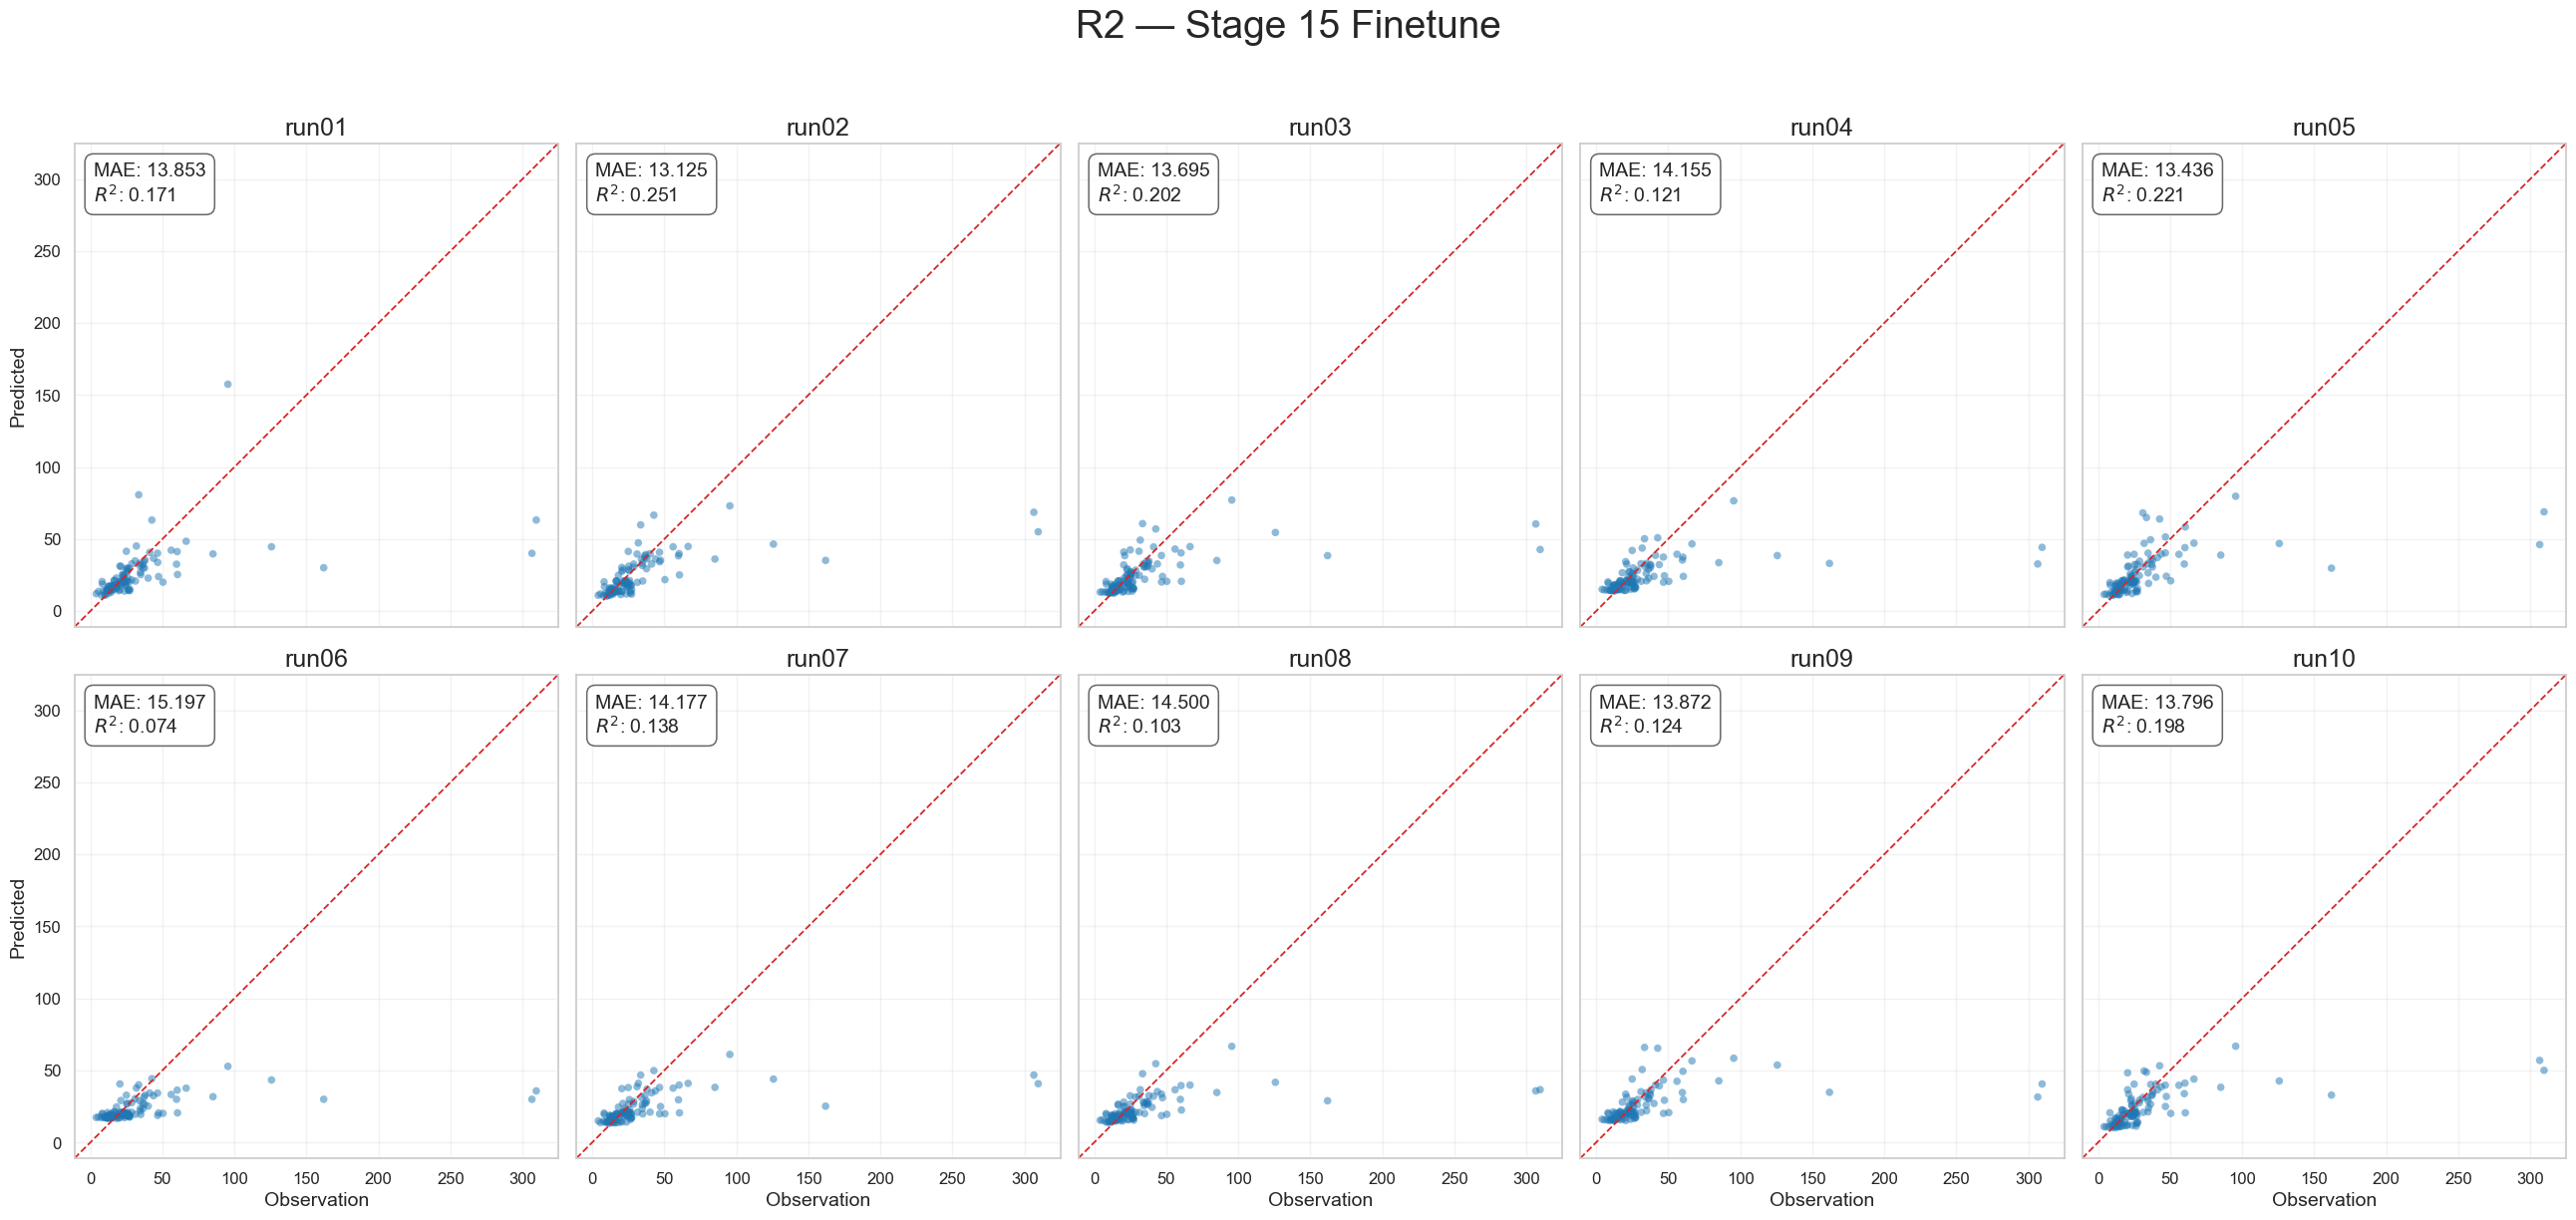

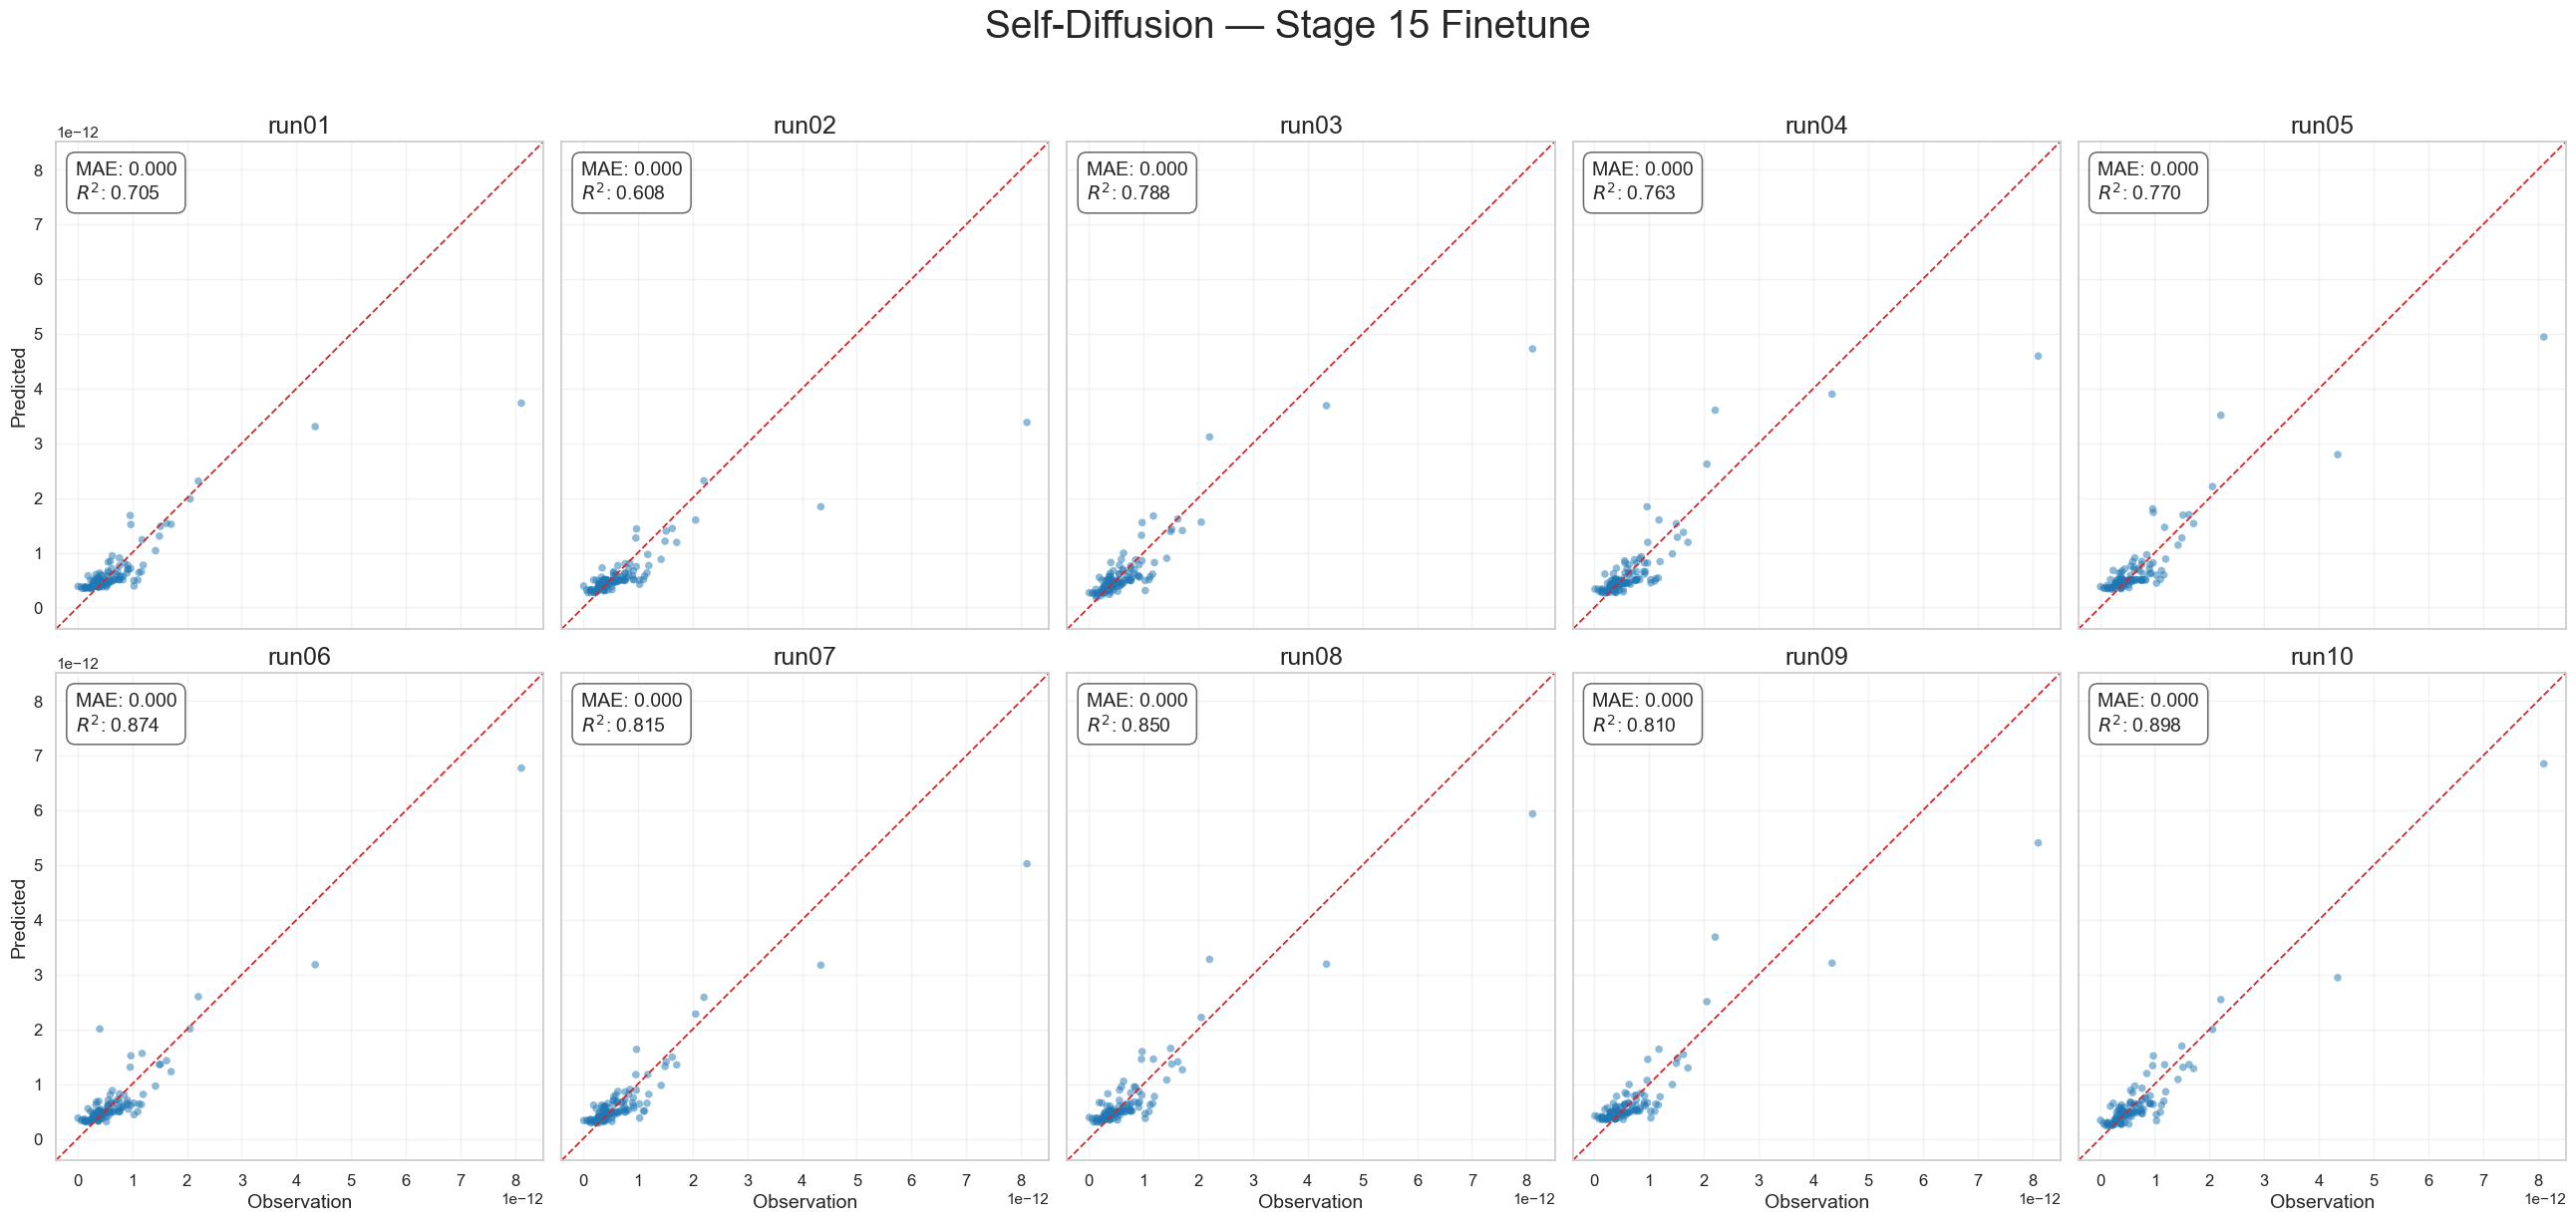

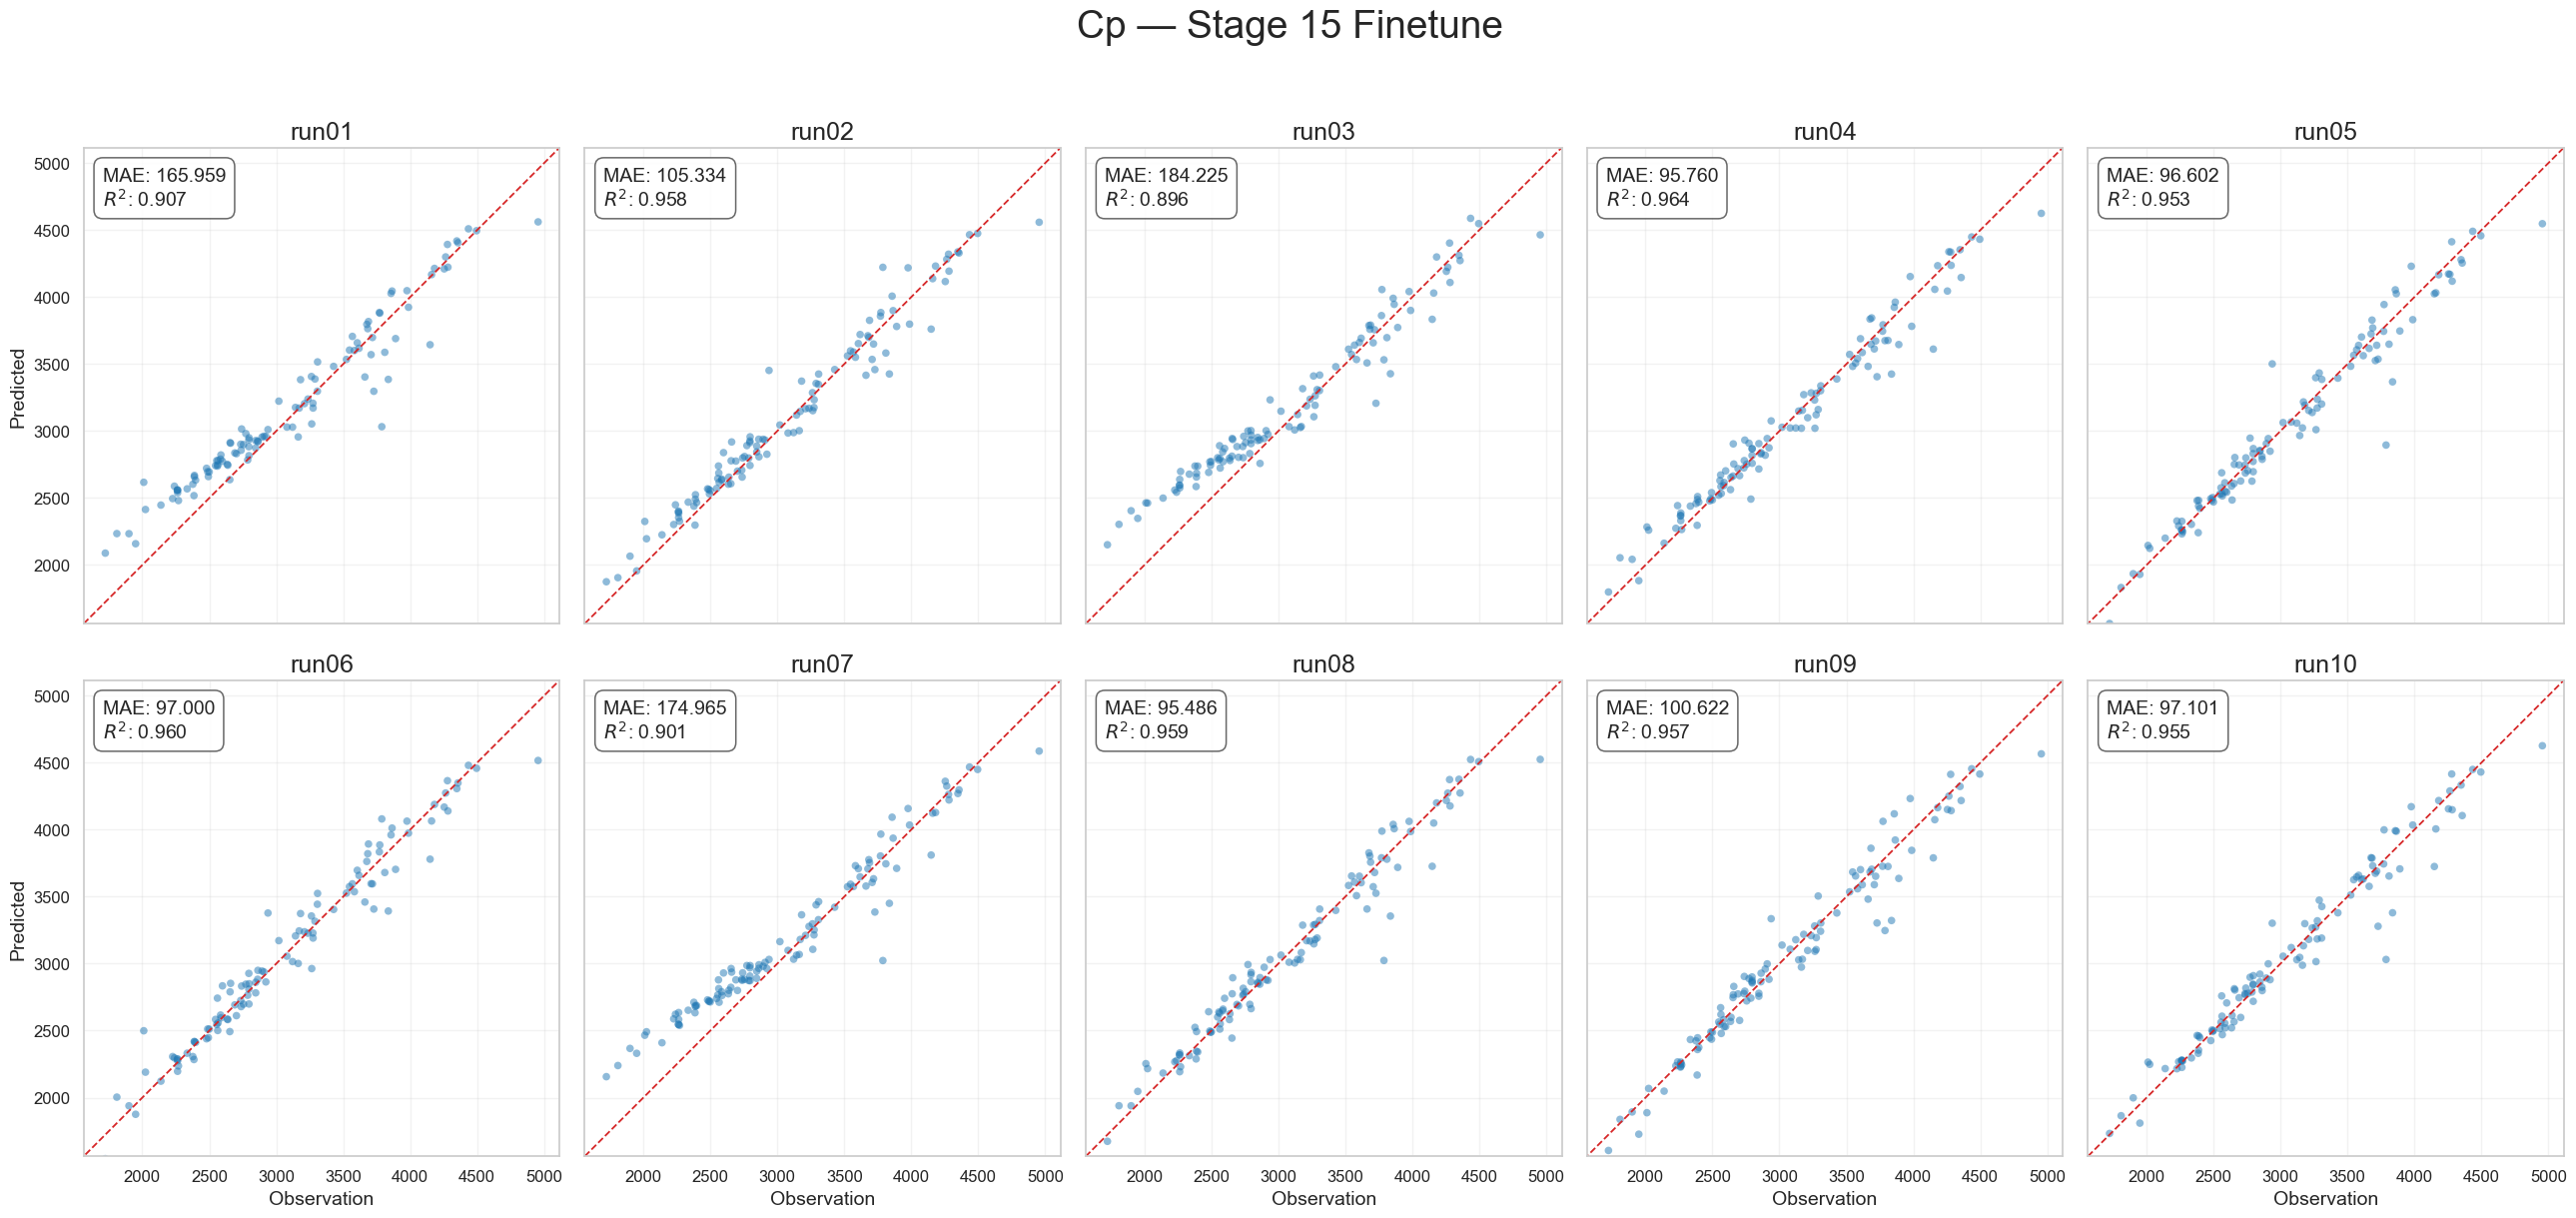

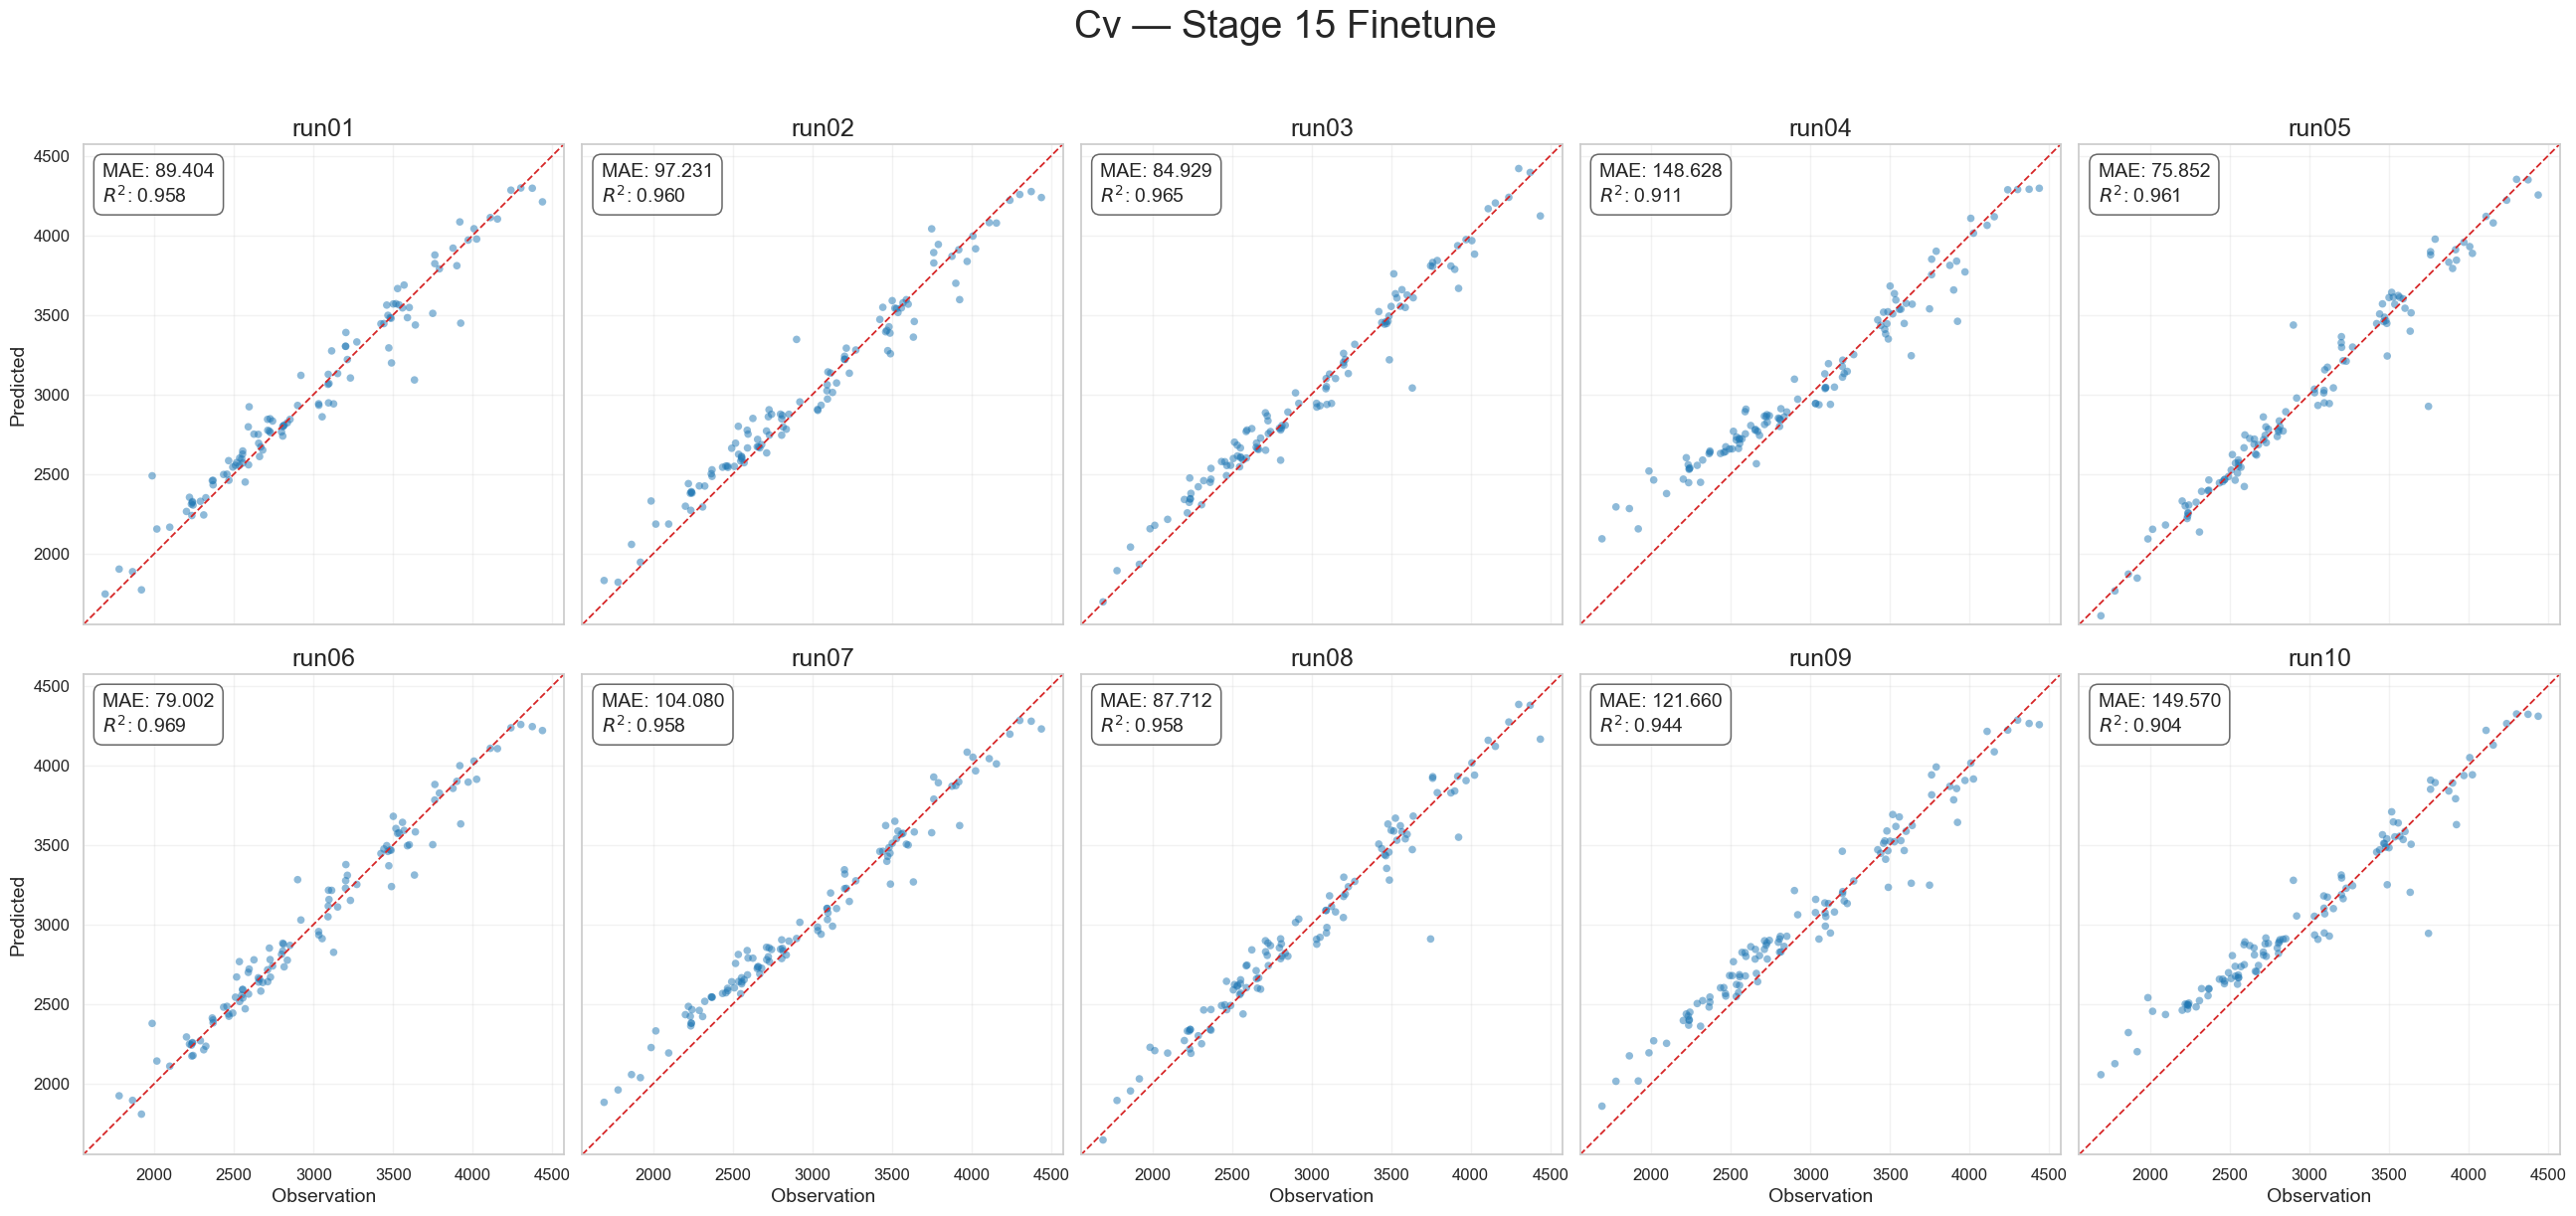

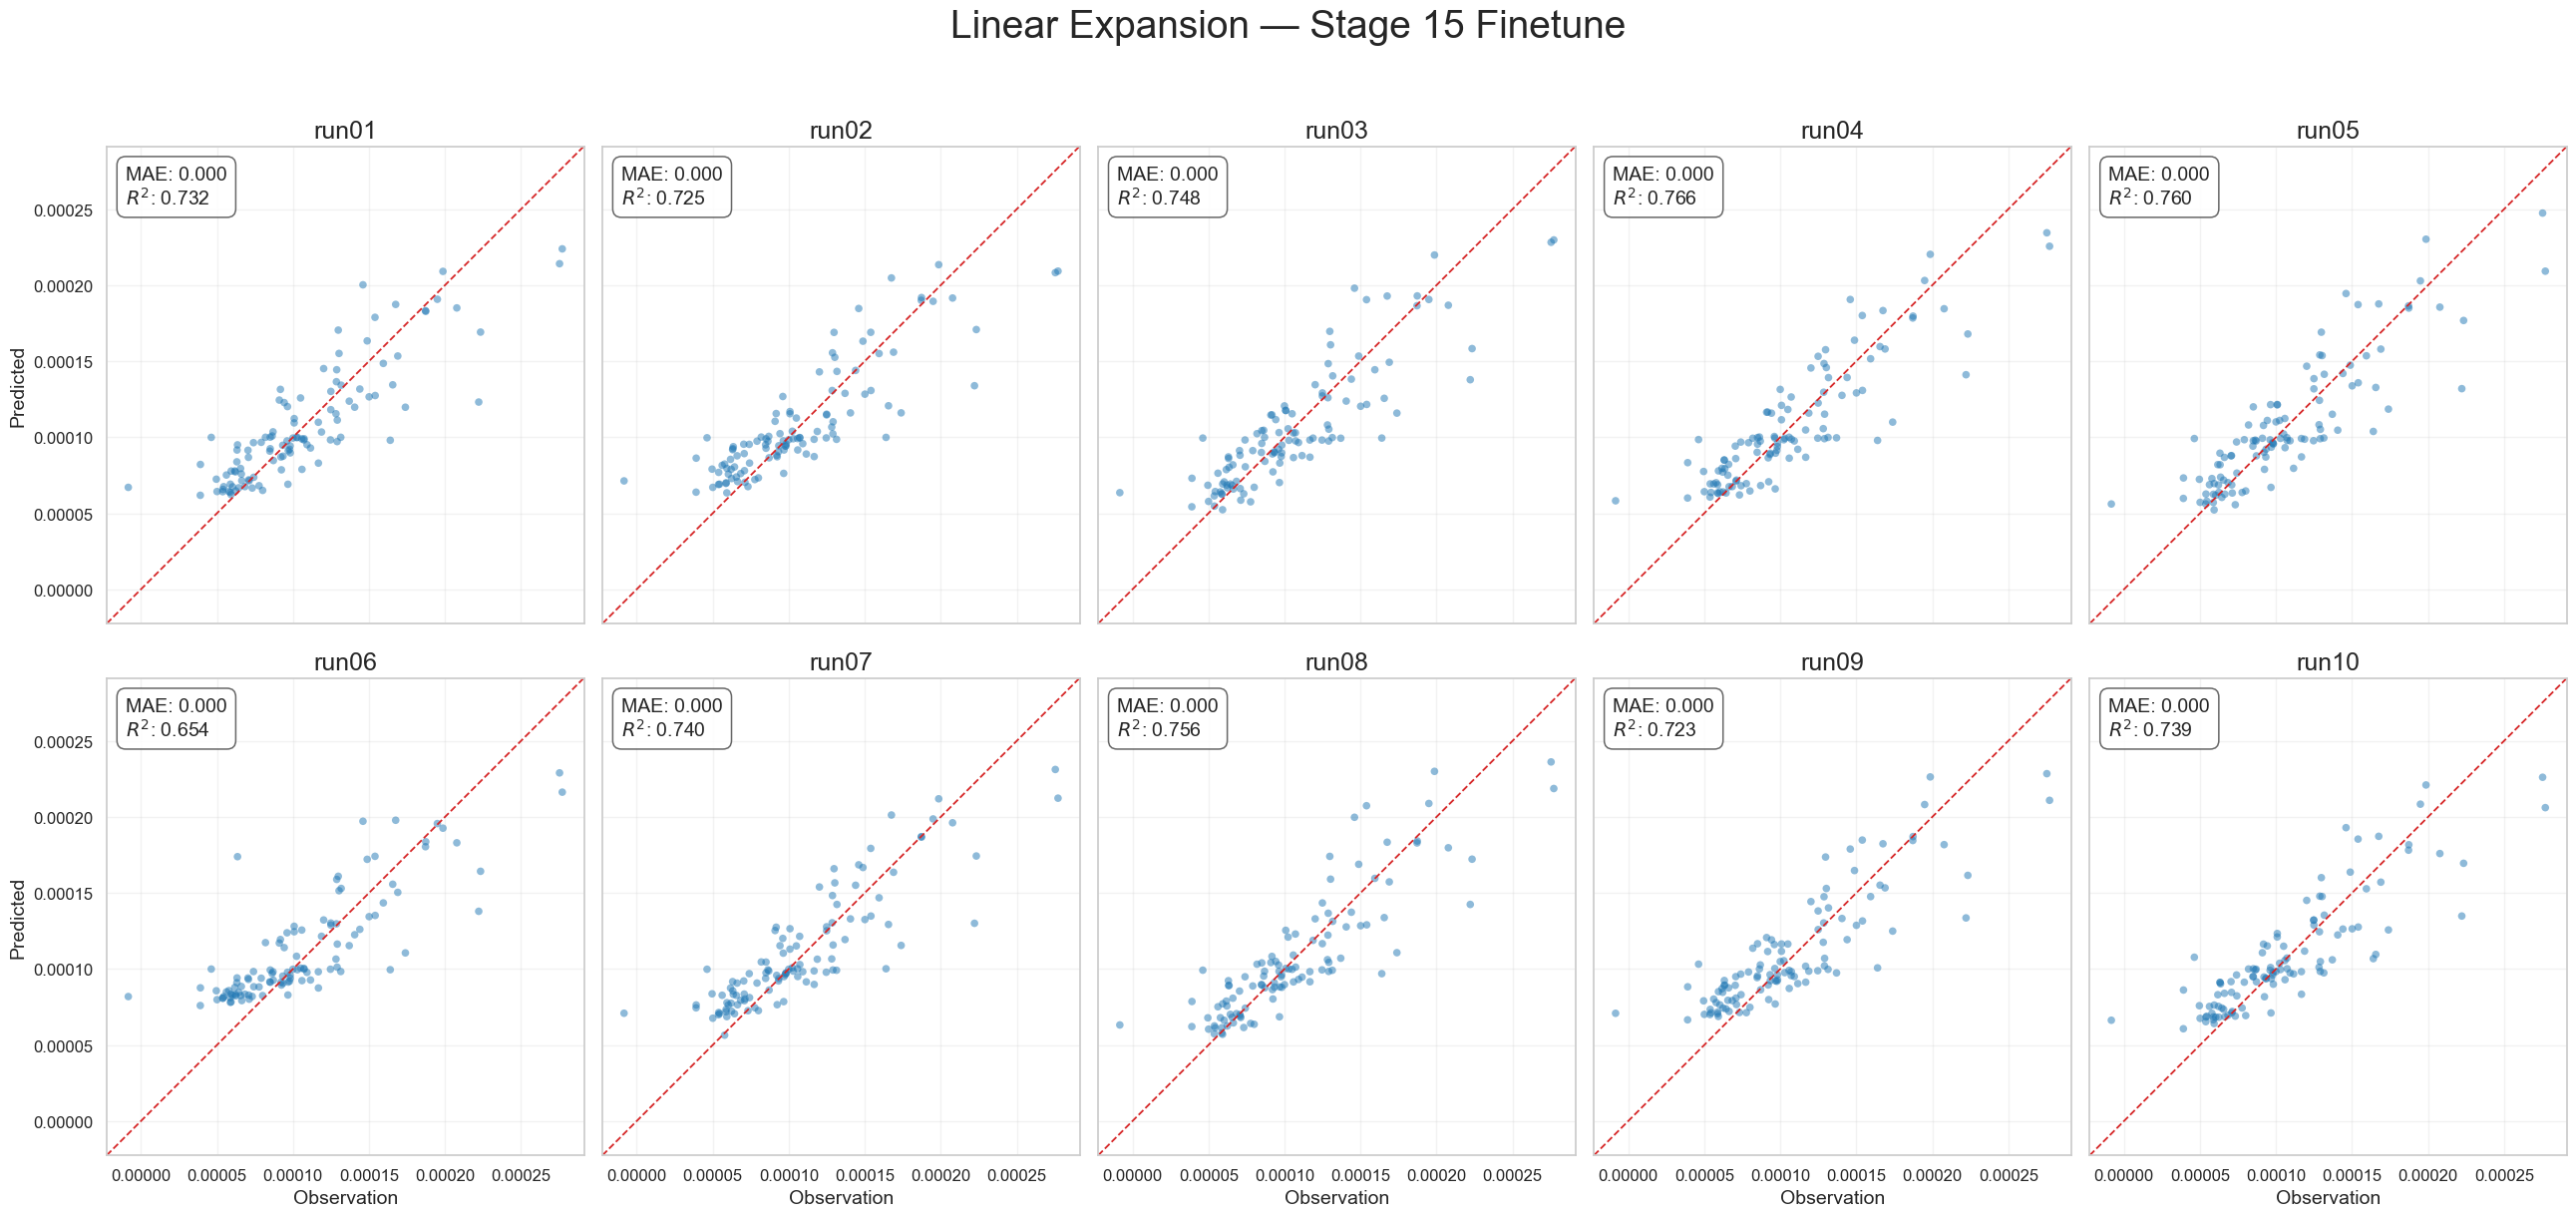

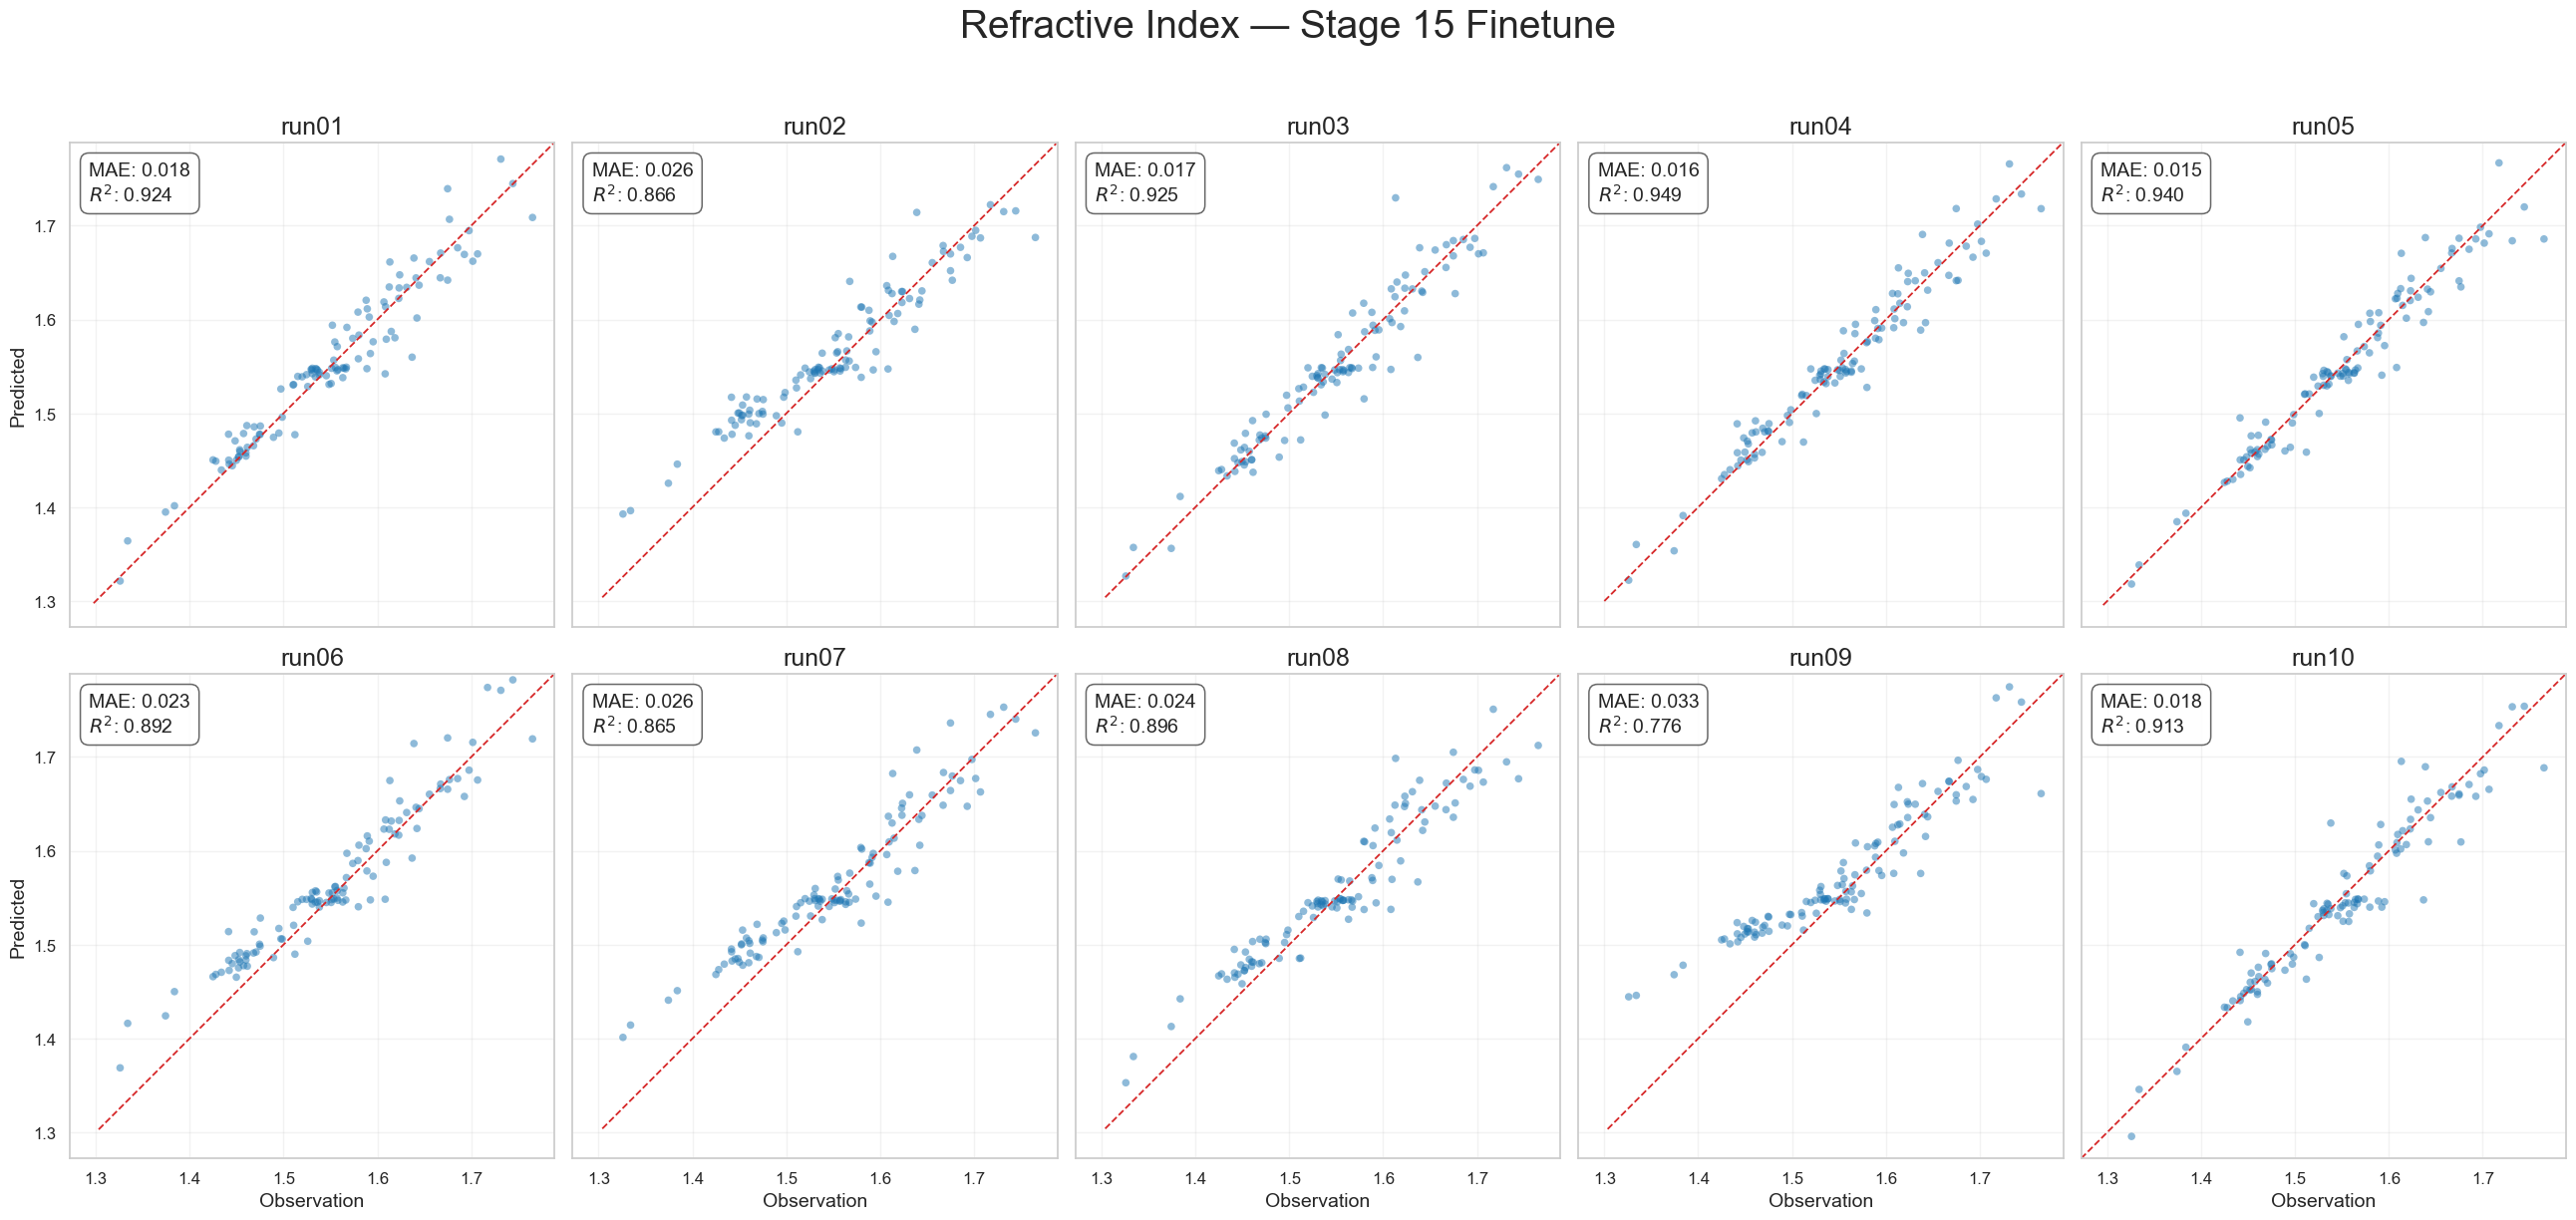

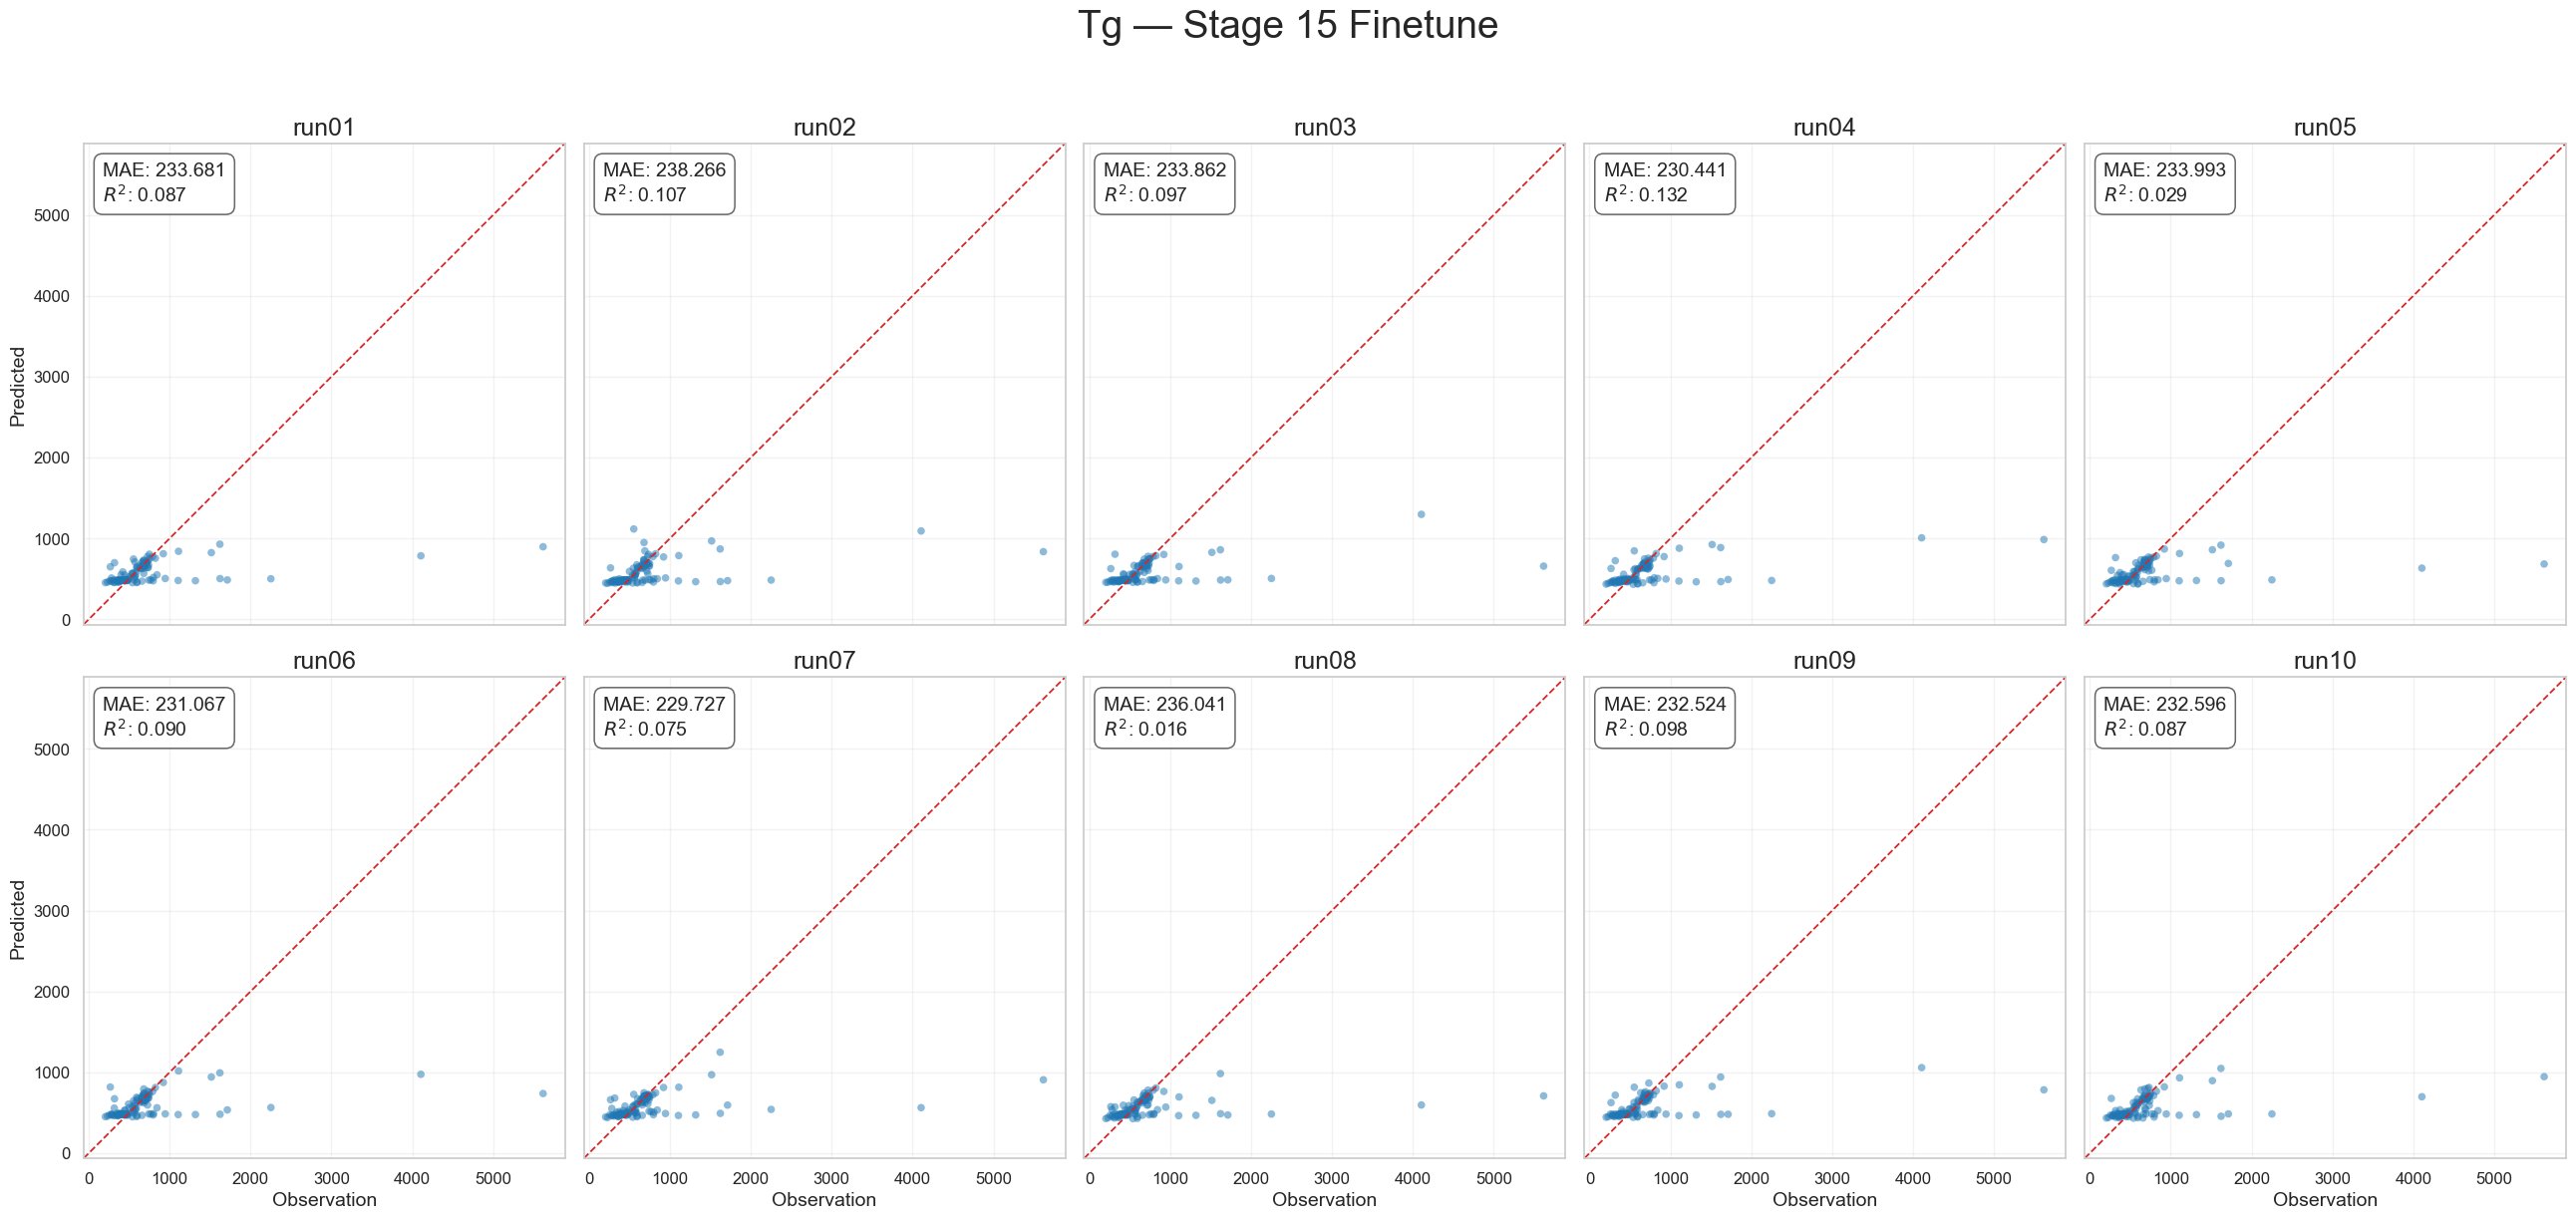

In [5]:
sns.set_theme(style="whitegrid", context="notebook")
figsize = (26, 12)
run_order = [f"run{i:02d}" for i in range(1, 11)]

for property_name in FINETUNE_PROPERTIES:
    df = prediction_data[property_name]
    fig, axes = plt.subplots(2, 5, figsize=figsize, sharex=True, sharey=True)
    axes = axes.flatten()

    if df.empty:
        for ax in axes:
            ax.axis("off")
        fig.suptitle(f"{property_name.replace('_', ' ').title()} — no data", fontsize=26)
        plt.tight_layout()
        plt.show()
        continue

    grouped = {run: frame for run, frame in df.groupby("run_dir")}

    for idx, (ax, run_label) in enumerate(zip(axes, run_order)):
        run_df = grouped.get(run_label)
        if run_df is None or run_df.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=16, color="gray")
            ax.axis("off")
            continue

        actual = run_df["actual"].to_numpy()
        predicted = run_df["predicted"].to_numpy()
        ax.scatter(actual, predicted, s=30, alpha=0.5, edgecolor="none", color="tab:blue")

        lo = min(actual.min(), predicted.min())
        hi = max(actual.max(), predicted.max())
        pad = 0.05 * (hi - lo) if hi > lo else 0.1
        lo -= pad
        hi += pad
        ax.plot([lo, hi], [lo, hi], "--", color="tab:red", linewidth=1.3)
        ax.set_xlim(lo, hi)
        ax.set_ylim(lo, hi)
        ax.set_aspect("equal", adjustable="box")

        residuals = predicted - actual
        mae = float((abs(residuals)).mean())
        ss_tot = float(((actual - actual.mean()) ** 2).sum())
        ss_res = float((residuals**2).sum())
        r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else None

        annotation = [f"MAE: {mae:.3f}", rf"$R^2$: {r2:.3f}" if r2 is not None else "$R^2$: N/A"]
        ax.text(
            0.04,
            0.96,
            "\n".join(annotation),
            transform=ax.transAxes,
            fontsize=14,
            verticalalignment="top",
            bbox=dict(
                boxstyle="round,pad=0.45",
                facecolor="white",
                edgecolor="0.3",
                linewidth=1.1,
                alpha=0.85,
            ),
        )

        ax.set_title(run_label, fontsize=18)
        if idx >= 5:
            ax.set_xlabel("Observation", fontsize=14)
        if idx % 5 == 0:
            ax.set_ylabel("Predicted", fontsize=14)
        ax.tick_params(labelsize=12)
        ax.grid(alpha=0.25)

    for ax in axes[len(run_order) :]:
        ax.axis("off")

    fig.suptitle(f"{property_name.replace('_', ' ').title()} — Stage {STAGE_INDEX} Finetune", fontsize=28, y=1.02)
    plt.tight_layout()
    plt.show()